In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import corner
from scipy.io.idl import readsav

In [2]:
# Read in the previous data release as well as the MARCS2014 atmosphere grid
data = Table.read('/Users/svenbuder/GALAH_DR3/catalogs/GALAH_DR3_all_joined_v2.fits')
marcs2014 = readsav('marcs2014/marcs2014.sav')

\caption{Coverage in \Teff and \logg of MARCS2014 grid (red) and GALAH DR3 (black, including density countour). Shown is also an example of one of the 3D bins used to create models with \TheCannon. MARCS grid points \Teff$\leq3100\K$ are neglected throughout GALAH DR4.}


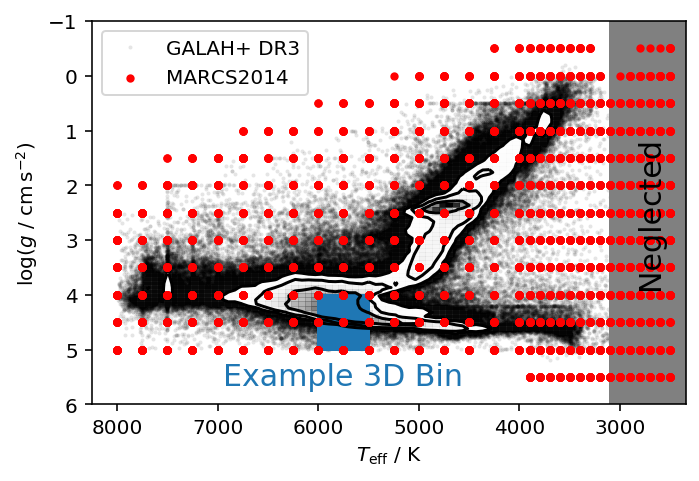

In [21]:
def plot_teff_logg_coverage():
    unflagged = np.isfinite(data['teff'])
    f, ax = plt.subplots(figsize=(5,3.5))
    corner.hist2d(
        data['teff'][unflagged],
        data['logg'][unflagged],
        bins=75,
        levels=(0.4,0.7,0.86,),
        data_kwargs=dict(label='GALAH+ DR3',alpha=0.1),
        ax=ax
    )
    ax.scatter(
        marcs2014['atmo_grid']['teff'],
        marcs2014['atmo_grid']['logg'],
        label='MARCS2014',
        s=10,c='r',
        zorder=4
    )
    ax.add_patch(Rectangle((5750-250, 4.0), 500, 1.0,color="C0"))
    ax.text(5750,5.5,'Example 3D Bin',ha='center',va='center',color='C0',fontsize=15)
    ax.text(2700,2.5,'Neglected',ha='center',va='center',color='k',fontsize=15,rotation=90,zorder=5)
    ax.axvspan(2000,3100,color='grey')
    ax.legend(loc='upper left')
    ax.set_xlim(8250,2350)
    ax.set_ylim(6.,-1.)
    ax.set_xlabel(r'$T_\mathrm{eff}$ / K')
    ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$')
    plt.tight_layout()
    plt.savefig('../galah_dr4_paper/figures/teff_logg_grid_coverage.png',dpi=200,bbox_inches='tight')
    print('\caption{Coverage in \Teff and \logg of MARCS2014 grid (red) and GALAH DR3 (black, including density countour). Shown is also an example of one of the 3D bins used to create models with \TheCannon. MARCS grid points \Teff$\leq3100\K$ are neglected throughout GALAH DR4.}')

plot_teff_logg_coverage()

## Create a set of subgrids in 3D bins of $T_\text{eff}$, $\log g$, and [Fe/H]

In [37]:
# First let's use all uniqe grid points
teff_points = np.unique(marcs2014['atmo_grid']['TEFF'])
logg_points = np.unique(marcs2014['atmo_grid']['LOGG'])
fe_h_points = np.unique(marcs2014['atmo_grid']['MONH'])
# Now let's ignore the Teff <= 3100 K
teff_points = teff_points[teff_points>=3100]

# We will want to safe a FITS file that will help us to identify the individual subgrids
subgrid_index = []
subgrid_teff_low = []
subgrid_teff_mid = []
subgrid_teff_high = []
subgrid_logg_low = []
subgrid_logg_mid = []
subgrid_logg_high = []
subgrid_fe_h_low = []
subgrid_fe_h_mid = []
subgrid_fe_h_high = []
subgrid_seed = []

running_subgrid_index = 0

# Now let's loop through all available teff/logg/feh and take +- 1 from the unique grid points
for teff in teff_points[1:-2]:
    for logg in logg_points[1:-2]:
        for fe_h in fe_h_points[3:-2]:
                        
            teff_i = np.where(teff==teff_points)[0][0]
            logg_i = np.where(logg==logg_points)[0][0]
            fe_h_i = np.where(fe_h==fe_h_points)[0][0]
            
            gridpoints = np.where((
                    (marcs2014['atmo_grid']['TEFF'] >= teff_points[teff_i-1]) &
                    (marcs2014['atmo_grid']['TEFF'] <= teff_points[teff_i+1]) &
                    (marcs2014['atmo_grid']['LOGG'] >= logg_points[logg_i-1]) &
                    (marcs2014['atmo_grid']['LOGG'] <= logg_points[logg_i+1]) &
                    (marcs2014['atmo_grid']['MONH'] >= fe_h_points[fe_h_i-1]) &
                    (marcs2014['atmo_grid']['MONH'] <= fe_h_points[fe_h_i+1])
                ) == True)[0]

            if len(gridpoints) > 1:
                subgrid_index.append(running_subgrid_index)
                subgrid_teff_low.append(teff_points[teff_i-1])
                subgrid_teff_mid.append(teff)
                subgrid_teff_high.append(teff_points[teff_i+1])
                
                subgrid_logg_low.append(logg_points[logg_i-1])
                subgrid_logg_mid.append(logg)
                subgrid_logg_high.append(logg_points[logg_i+1])

                subgrid_fe_h_low.append(fe_h_points[fe_h_i-1])
                subgrid_fe_h_mid.append(fe_h)
                subgrid_fe_h_high.append(fe_h_points[fe_h_i+1])
                
                subgrid_seed.append(int(teff+10*logg+100*fe_h))

                running_subgrid_index += 1

# 1892 if running +- 1 point
print(running_subgrid_index)

2193


In [40]:
subgrid_table = Table()
subgrid_table['index_subgrid'] = np.array(subgrid_index)

subgrid_table['teff_subgrid'] = np.array(subgrid_teff_mid)
subgrid_table['teff_low_subgrid'] = np.array(subgrid_teff_low)
subgrid_table['teff_high_subgrid'] = np.array(subgrid_teff_high)

subgrid_table['logg_subgrid'] = np.array(subgrid_logg_mid)
subgrid_table['logg_low_subgrid'] = np.array(subgrid_logg_low)
subgrid_table['logg_high_subgrid'] = np.array(subgrid_logg_high)

subgrid_table['fe_h_subgrid'] = np.array(subgrid_fe_h_mid)
subgrid_table['fe_h_low_subgrid'] = np.array(subgrid_fe_h_low)
subgrid_table['fe_h_high_subgrid'] = np.array(subgrid_fe_h_high)

subgrid_table['random_seed_subgrid'] = np.array(subgrid_seed)

subgrid_table.write('galah_dr4_model_trainingset_gridpoints.fits',overwrite='True')

subgrid_table

index_subgrid,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
0,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-2.5,-3.0,-2.0,2950
1,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-2.0,-2.5,-1.5,3000
2,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-1.5,-2.0,-1.0,3050
3,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-1.0,-1.5,-0.75,3100
4,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-0.75,-1.0,-0.5,3125
5,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-0.5,-0.75,-0.25,3150
6,3200.0,3100.0,3300.0,0.0,-0.5,0.5,-0.25,-0.5,0.0,3175
7,3200.0,3100.0,3300.0,0.0,-0.5,0.5,0.0,-0.25,0.25,3200
8,3200.0,3100.0,3300.0,0.0,-0.5,0.5,0.25,0.0,0.5,3225


# Calculate 280 points

In [189]:
def calculate_sme_abundance_table(sample):
    #       "H",  "He",  "Li",  "Be",   "B",   "C",   "N",   "O",   "F",  "Ne",
    a_x= [12.00, 10.93,  1.05,  1.38,  2.70,  8.39,  7.78,  8.66,  4.56,  7.84,
    #      "Na",  "Mg",  "Al",  "Si",   "P",   "S",  "Cl",  "Ar",   "K",  "Ca",
           6.17,  7.53,  6.37,  7.51,  5.36,  7.14,  5.50,  6.18,  5.08,  6.31,
    #      "Sc",  "Ti",   "V",  "Cr",  "Mn",  "Fe",  "Co",  "Ni",  "Cu",  "Zn",
           3.17,  4.90,  4.00,  5.64,  5.39,  7.45,  4.92,  6.23,  4.21,  4.60,
    #      "Ga",  "Ge",  "As",  "Se",  "Br",  "Kr",  "Rb",  "Sr",   "Y",  "Zr",
           2.88,  3.58,  2.29,  3.33,  2.56,  3.25,  2.60,  2.92,  2.21,  2.58,
    #      "Nb",  "Mo",  "Tc",  "Ru",  "Rh",  "Pd",  "Ag",  "Cd",  "In",  "Sn",
           1.42,  1.92, -8.00,  1.84,  1.12,  1.66,  0.94,  1.77,  1.60,  2.00,
    #      "Sb",  "Te",   "I",  "Xe",  "Cs",  "Ba",  "La",  "Ce",  "Pr",  "Nd",
           1.00,  2.19,  1.51,  2.24,  1.07,  2.17,  1.13,  1.70,  0.58,  1.45,
    #      "Pm",  "Sm",  "Eu",  "Gd",  "Tb",  "Dy",  "Ho",  "Er",  "Tm",  "Yb",
          -8.00,  1.00,  0.52,  1.11,  0.28,  1.14,  0.51,  0.93,  0.00,  1.08,
    #      "Lu",  "Hf",  "Ta",   "W",  "Re",  "Os",  "Ir",  "Pt",  "Au",  "Hg",
           0.06,  0.88, -0.17,  1.11,  0.23,  1.25,  1.38,  1.64,  1.01,  1.13,
    #      "Tl",  "Pb",  "Bi",  "Po",  "At",  "Rn",  "Fr",  "Ra",  "Ac",  "Th",
           0.90,  2.00,  0.65, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00,  0.06,
    #      "Pa",   "U",  "Np",  "Pu",  "Am",  "Cm",  "Bk",  "Cs",  "Es", "TiO" 
          -8.00, -0.52, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00]
    log_eonh = np.array(a_x) - 12.0
    
    elements = np.array(['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu'])
    element_indices = np.array([3,6,7,8,11,12,13,14,19,20,21,22,23,24,25,27,28,29,30,37,38,39,40,42,44,56,57,58,60,62,63])-1
    
    for index, element in enumerate(elements):
        element_index = element_indices[index]
        log_eonh[element_index] += sample[element.lower()+'_fe']
    
    eonh = 10**log_eonh
    renorm = np.sum(eonh)
    eontot = eonh / renorm
    log_eontot = np.log10(eontot).astype(np.float)
    abund = log_eontot
    abund[0] = eonh[0] / renorm
    abund = abund.astype(np.float)
    return(abund)

In [190]:
coefficient_test_labels = [
    'teff','logg','fe_h','vmic',
    'li_fe','c_fe','n_fe','o_fe',
    'na_fe','mg_fe','al_fe','si_fe',
    'k_fe','ca_fe','sc_fe','ti_fe','v_fe','cr_fe','mn_fe','co_fe','ni_fe','cu_fe','zn_fe',
    'rb_fe','sr_fe','y_fe','zr_fe','mo_fe','ru_fe',
    'ba_fe','la_fe','ce_fe','nd_fe','sm_fe','eu_fe'
]

In [194]:
for index in subgrid_table['index_subgrid'][1592:1594]:
        
    coefficient_test = dict()
    coefficient_test['spectrum_index'] = []
    for label in coefficient_test_labels:
        coefficient_test[label] = []

    grid_table = Table()
    spectrum_index = 0

    np.random.seed(subgrid_table['random_seed_subgrid'][index])
    
    teff_logg_feh_name = str(int(subgrid_table['teff_subgrid'][index]))+'_'+"{:.2f}".format(subgrid_table['logg_subgrid'][index])+'_'+"{:.2f}".format(subgrid_table['fe_h_subgrid'][index])
        
    # let's create the null spectrum
    coefficient_test['spectrum_index'].append(spectrum_index)
    label_values = dict()
    for label in coefficient_test_labels:
        if label in ['teff','logg','fe_h']:
            label_values[label] = subgrid_table[label+'_subgrid'][index]
        elif label == 'vmic':
            label_values[label] = 1.5
        elif label == 'li':
            label_values[label] = 2.75 - 1.05 - label_values['fe_h'] # SBBN A(Li) - A(Li_sun) from Pitrou+18 and Asplund+09
        else:
            label_values[label] = 0.0
        coefficient_test[label].append(label_values[label])
            
    spectrum_index += 1
    
    # let's create another null spectrum, but this time with an adjusted vmic
    coefficient_test['spectrum_index'].append(spectrum_index)
    label_values = dict()
    for label in coefficient_test_labels:
        if label in ['teff','logg','fe_h']:
            label_values[label] = subgrid_table[label+'_subgrid'][index]
        elif label == 'vmic':
            if (label_values['logg'] <= 4.2) | (label_values['teff'] >= 5500):
                label_values[label] = 1.1 + 10**(-4)*(label_values['teff'] - 5500) + 4*10**(-7)*(label_values['teff'] - 5500)**2
            else:
                label_values[label] = 1.5 + 2*10**(-4)*(label_values['teff'] - 5500)
            print(label_values[label])
        elif label == 'li':
            label_values[label] = 2.75 - 1.05 - label_values['fe_h'] # SBBN A(Li) - A(Li_sun) from Pitrou+18 and Asplund+09
        else:
            label_values[label] = 0.0
        coefficient_test[label].append(label_values[label])
            
    spectrum_index += 1

    # let's crate the spectra with 1 parameter increased at a time
    for coefficient_label in coefficient_test_labels:
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = subgrid_table[label+'_subgrid'][index]
                if coefficient_label == label:
                    label_values[label] = subgrid_table[label+'_high_subgrid'][index]
            elif label == 'vmic':
                label_values[label] = 1.5
                if coefficient_label == label:
                    label_values[label] += 1.0
            elif label == 'li':
                label_values[label] = 2.75 - 1.05 - subgrid_table['fe_h_subgrid'][index] # SBBN A(Li) - A(Li_sun) from Pitrou et al. (2018) and Asplund et al. (2009)
                if coefficient_label == label:
                    label_values[label] += 1.0
            else:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] += 1.0
            coefficient_test[label].append(label_values[label])
        
        spectrum_index += 1
    
    # let's crate the spectra with 1 parameter increased at a time
    for coefficient_label in coefficient_test_labels:
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = subgrid_table[label+'_subgrid'][index]
                if coefficient_label == label:
                    label_values[label] = subgrid_table[label+'_low_subgrid'][index]
            elif label == 'vmic':
                label_values[label] = 1.5
                if coefficient_label == label:
                    label_values[label] -= 1.0
            elif label == 'li':
                label_values[label] = 2.75 - 1.05 - subgrid_table['fe_h_subgrid'][index] # SBBN A(Li) - A(Li_sun) from Pitrou et al. (2018) and Asplund et al. (2009)
                if coefficient_label == label:
                    label_values[label] -= 1.0
            else:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] -= 1.0
            coefficient_test[label].append(label_values[label])
        
        spectrum_index += 1

    # let's create the spectra with +- 0.5 dex
    for each_sample_index in range(104):
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = np.random.uniform(
                    low = subgrid_table[label+'_low_subgrid'][index],
                    high = subgrid_table[label+'_high_subgrid'][index]
                )
            elif label == 'li':
                label_values[label] = np.random.uniform(
                    low = 1.05 - 1.05 - label_values['fe_h'] - 0.5, # A(Li_sun) - 0.5 (Asplund et al., 2009)
                    high = 3.26 - 1.05 - label_values['fe_h'] + 0.5 # A(Li_meteorites) + 0.5 (Asplund et al., 2009)
                )
            elif label in ['o','y','ba']:
                label_values[label] = np.random.uniform(
                    low = -1.0,
                    high = 1.0
                )
            else:
                label_values[label] = np.random.uniform(
                    low = -0.5,
                    high = +0.5
                )
            coefficient_test[label].append(label_values[label])
        spectrum_index += 1

    # let's create the spectra with +- 1.0 dex
    for each_sample_index in range(104):
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = np.random.uniform(
                    low = subgrid_table[label+'_low_subgrid'][index],
                    high = subgrid_table[label+'_high_subgrid'][index]
                )
            elif label == 'li':
                label_values[label] = np.random.uniform(
                    low = -1.0 - 1.05 - label_values['fe_h'], # A(Li) = -1.0
                    high = +5.0 - 1.05 - label_values['fe_h'] # A(Li) = 5.0
                )
            elif label in ['o','y','ba']:
                label_values[label] = np.random.uniform(
                    low = -2.0,
                    high = 2.0
                )
            else:
                label_values[label] = np.random.uniform(
                    low = -1.0,
                    high = +1.0
                )
            coefficient_test[label].append(label_values[label])
        spectrum_index += 1

    print(index,)
    
    grid_table['grid_index'] = np.array([index for x in range(280)])
    grid_table['spectrum_index'] = np.array(coefficient_test['spectrum_index'])
    for label in coefficient_test_labels:
        grid_table[label] = np.array(coefficient_test[label],dtype=np.float32)
        
    grid_table['sme_abund'] = np.array([calculate_sme_abundance_table(sample=grid_table[index]) for index in range(len(grid_table))])
    
    grid_table.write('3d_bin_subgrids/'+teff_logg_feh_name+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'.fits',overwrite=True)

1.15
1592
1.15
1593
